In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import random
import textwrap
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
stopwords = set(stopwords.words('english'))
import time
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

2024-08-06 10:06:00.257660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 10:06:00.257763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 10:06:00.384239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Dataset Pre Processing and Loading

In [2]:
df=pd.read_csv('/kaggle/input/flickr8k/captions.txt',sep=',')
captions_by_image = df.groupby('image')['caption'].apply(list).to_dict()

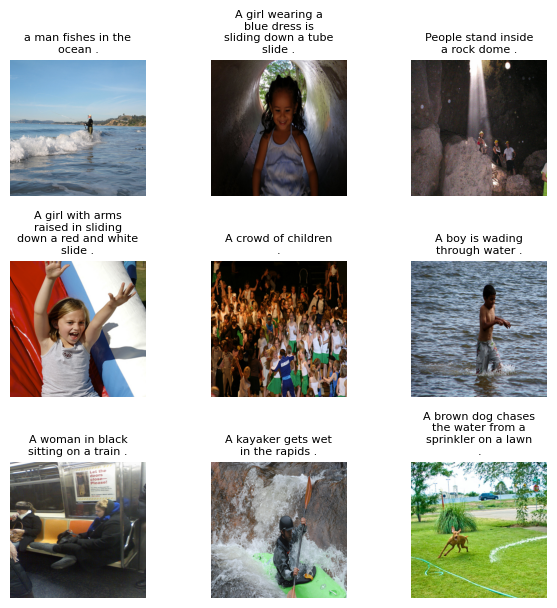

In [3]:
images_folder = '/kaggle/input/flickr8k/Images'
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
num_images = 9  
selected_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(3, 3, figsize=(7, 7))  
axs_flat = axs.flatten()

for i, image_file in enumerate(selected_images):
    img = Image.open(os.path.join(images_folder, image_file))
    img_resized = img.resize((256, 256))  
    axs_flat[i].imshow(img_resized)
    axs_flat[i].axis('off')
    title = captions_by_image[image_file][0]
    wrapped_title = textwrap.fill(title, width=20)  
    axs_flat[i].set_title(wrapped_title, fontsize=8)  

plt.tight_layout(pad=4.0, h_pad=1.0, w_pad=1.0)  
plt.show()

In [4]:
# text cleaning

def rm_link(text):
    #This function removes links from the text
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    #This function removes punctuations from the text
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
#     return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    #This function removes html tags from the text
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    #This function adds space between punctuation
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    #This function removes numbers from the text
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    #This function removes extra whitespaces from the text
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    #This function removes non-ascii characters from the text
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    #This function removes emojis from the text
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    #This function corrects the spelling of the text by removing repeating characters whose frequency is greater than 2
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    text = str(text)    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    # no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_punct)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t).lower() for t in text] #Also converting to lower case
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

df['clean'] = df['caption'].progress_apply(clean_pipeline)
df['processed'] = df['clean'].progress_apply(preprocess_pipeline)
data = df[['image', 'processed']]
data.head()

100%|██████████| 40455/40455 [00:10<00:00, 3922.52it/s]


,image,processed
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stair entry way
1,1000268201_693b08cb0e.jpg,girl going wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing stair playhouse
4,1000268201_693b08cb0e.jpg,little girl pink dress going wooden cabin


In [5]:
from collections import Counter

# Building Vocab
text = data['processed'].values
text = [str(item) for item in text]
words = ' '.join(text)
words = words.split()

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 3))
int2word[0] = '<PAD>'
int2word[1] = '<START>'
int2word[2] = '<END>'
# Vocab size: 7297 
word2int = {word: id for id, word in int2word.items()}

seq_length = 128

data.loc[:, 'processed'] = data['processed'].apply(lambda sentence: [1] + [word2int[word] for word in str(sentence).split()] + [2])
data.loc[:, 'processed'] = data['processed'].apply(lambda sentence: sentence + [0] * (seq_length - len(sentence)) if len(sentence) < seq_length else sentence[:seq_length])

In [6]:
captions_by_image2 = data.groupby('image')['processed'].apply(list).to_dict()

In [7]:

class FlickrDataset(Dataset):
    def __init__(self, images_folder, captions_by_image2, transform=None):
        self.images_folder = images_folder
        self.captions_by_image2 = captions_by_image2
        self.image_files = os.listdir(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image_path = os.path.join(self.images_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(self.captions_by_image2.get(image_file))
        return image, labels

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

dataset = FlickrDataset(images_folder='/kaggle/input/flickr8k/Images', captions_by_image2=captions_by_image2,transform=transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [6491, 800, 800])


In [8]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

### Model Architecture

Using merge architecture that is mentioned in paper "Where to put image?"

In [9]:
hidden_size = 256
num_layers = 1
sequence_length = seq_length
embedding_dim = 256
vocab_size = len(word2int)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EncoderCNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers, vocab_size):
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, embedding_dim)
        self.normalise=nn.BatchNorm1d(embedding_dim)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True) #Don't have to specify sequence length becuase it can work on variable sequence length
        self.linear_final = nn.Linear(hidden_size, embedding_dim)
        
    def forward(self, images,captions):
        features = self.resnet(images)
        features_normalised_squeezed=self.normalise(features)
        sequence_length = captions.size(1)
        features_normalised=features_normalised_squeezed.unsqueeze(1).repeat(1,sequence_length,1)
        # print("Shape of features_normalised is",features_normalised.shape)
        #Shape of features_normalised is (batch_size,sequence_length,embedding_dim)
        embeddings=self.embedding(captions)
        # print("Shape of embeddings is",embeddings.shape)
        #Shape of embeddings is (batch_size,sequence_length,input_size)
        h0 = torch.zeros(self.num_layers, embeddings.size(0), self.hidden_size).to(device) #(num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, embeddings.size(0), self.hidden_size).to(device) #(num_layers, batch_size, hidden_size)
        out, _ = self.lstm(embeddings, (h0,c0)) #Shape of out is (batch_size,sequence_length,hidden_size) & _ is previous hidden state and shape is (num_layers,hidden_size)
        # print("Shape of out is",out.shape)
        diffused_features=features_normalised+out
        # print("Shape of diffused_features is",diffused_features.shape)
        return diffused_features
    
class DecoderRNN(nn.Module):
    def __init__(self, embedding_dim,vocab_size):
        super().__init__()
        self.linear=nn.Linear(embedding_dim, embedding_dim)
        self.linear_finale = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, diffused_features):
        afterlinear1=self.linear(diffused_features)
        outputs=self.linear_finale(afterlinear1)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, embedding_dim,vocab_size, hidden_size, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embedding_dim,hidden_size, num_layers, vocab_size)
        self.decoder = DecoderRNN(embedding_dim,vocab_size)

    def forward(self, images, captions):
        diffused_features = self.encoder(images,captions)
        outputs = self.decoder(diffused_features)
        return outputs

In [10]:
#BLEU Score
import collections
import math


def _get_ngrams(segment, max_order):
  """Extracts all n-grams upto a given maximum order from an input segment.

  Args:
    segment: text segment from which n-grams will be extracted.
    max_order: maximum length in tokens of the n-grams returned by this
        methods.

  Returns:
    The Counter containing all n-grams upto max_order in segment
    with a count of how many times each n-gram occurred.
  """
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  """Computes BLEU score of translated segments against one or more references.

  Args:
    reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
    translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.

  Returns:
    3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
    precisions and brevity penalty.
  """
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0
  if(reference_length==0):
    return 0
  ratio = float(translation_length) / reference_length
  if(ratio==0):
        return 0
  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return bleu


### Loss Function, Optimiser

In [11]:
def id_to_tokens(tensor):
    tokens=[]
    for t in tensor:
        id=t.item()
        if(id!=0 and id!=1 and id!=2):
            tokens.append(int2word[id])

    return [tokens]

def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_start_time = time.time()

    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0
    bleu_score=[]
    
    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X,y[:,0,:])
        ycorr = torch.cat((y[:,0,:][:,1:], torch.zeros(y.shape[0],1,dtype=torch.long).to(device)), dim=1).to(device)
        loss=loss_fn(pred.view(-1,pred.shape[-1]),ycorr.view(-1)) #loss_fn(nn.CrossEntropyLoss) expects the input to be of shape (N,C) where C is the number of classes. So we need to reshape the input and target to (N,C) where C is the number of classes.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()
        
        model.eval()
        pred=model(X,y[:,0,:])
        y_pred=pred.argmax(2)
        for i in range(y_pred.shape[0]):
            predicted=id_to_tokens(y_pred[i,:])
            references=[id_to_tokens(ycorr[i,:])]
            
            result=compute_bleu(references,predicted,max_order=3,smooth=True)
            bleu_score.append(result)
            
        train_correct_each = (pred.argmax(2) == ycorr).type(torch.float).sum().item()
        train_acc=train_correct_each/(ycorr.shape[0]*seq_length)
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)

        train_end_time = time.time() 
        train_duration = train_end_time - train_start_time 
        bleu_avg=sum(bleu_score)/len(bleu_score)

        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}] - Training Time: {train_duration:.2f}s - Average BLEU: {bleu_avg:>8f}", end="")

    loss_avg=loss_tot/num_batches
    train_acc = train_correct/(train_size*seq_length)

    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)

    model.eval()
    bleu_score_val=[]
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X,y[:,0,:])
            y_pred=pred.argmax(2)
            ycorr = torch.cat((y[:,0,:][:,1:], torch.zeros(y.shape[0],1,dtype=torch.long).to(device)), dim=1).to(device)
            for i in range(y_pred.shape[0]):
                predicted=id_to_tokens(y_pred[i,:])
                references=[id_to_tokens(ycorr[i,:])]
                result=compute_bleu(references,predicted,max_order=3,smooth=True)
                bleu_score_val.append(result)
            val_loss += loss_fn(pred.view(-1,pred.shape[-1]),ycorr.view(-1)).item()
            val_correct += (pred.argmax(2) == ycorr).type(torch.float).sum().item()
    val_loss /= len(val_dataloader)
    val_acc=val_correct/(val_size*seq_length)
    bleu_avg_val=sum(bleu_score_val)/len(bleu_score_val)
    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Average BLEU: {bleu_avg:>8f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f} - Average BLEU Validation: {bleu_avg_val:>8f} - Training Time: {train_duration:.2f}s")
    print(end='')
    writer.add_scalars('Training vs. Validation Loss',{ 'Training' : loss_avg, 'Validation' : val_loss },epoch +1)
    writer.add_scalars('Training vs. Validation Accuracy',{ 'Training' : train_acc, 'Validation' : val_acc },epoch +1)
    writer.add_scalars('Training vs. Validation BLEU Score',{ 'Training' : bleu_avg, 'Validation' : bleu_avg_val },epoch +1)
    return loss_avg, train_acc,bleu_avg, val_loss, val_acc , bleu_avg_val


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    bleu_score_test=[]
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X,y[:,0,:])
            ycorr = torch.cat((y[:,0,:][:,1:], torch.zeros(y.shape[0],1,dtype=torch.long).to(device)), dim=1).to(device)
            test_loss+=loss_fn(pred.view(-1,pred.shape[-1]),ycorr.view(-1)).item()
            correct += (pred.argmax(2) == ycorr).type(torch.float).sum().item()
            y_pred=pred.argmax(2)
            for i in range(y_pred.shape[0]):
                predicted=id_to_tokens(y_pred[i,:])
                references=[id_to_tokens(ycorr[i,:])]
                result=compute_bleu(references,predicted,max_order=3,smooth=True)
                bleu_score_test.append(result)
    test_loss /= num_batches
    test_acc=correct/(size*seq_length)
    bleu_avg_test=sum(bleu_score_test)/len(bleu_score_test)
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}% - Avg loss: {test_loss:>8f} - Avg BLEU: {bleu_avg_test:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'


model=ImageCaptioningModel(embedding_dim,vocab_size, hidden_size, num_layers).to(device)
learning_rate = 1e-3
batch_size = batch_size
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


sample_input_for_summary_captions = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
sample_input_for_summary_images = torch.randn(batch_size, 3, 224, 224).to(device)
# summary(model, input_data=(sample_input_for_summary_images,sample_input_for_summary_captions))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [12]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}
bleu_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 10  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy,bleu_avg, val_loss, val_accuracy,bleu_avg_val =train_loop(train_dataloader,validation_dataloader, model, loss_fn, optimizer,batch_size,t)
    # test_loop(test_dataloader, model, loss_fn)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)
    bleu_history['train'].append(bleu_avg) 
    bleu_history['val'].append(bleu_avg_val)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    if patience_counter >= patience:
        print(f"\nStopping early at epoch {t+1} with restoring best weights")
        epochs=t+1
        break 
writer.flush()

Epoch 1 : Training loss: 0.534231 - Training Accuracy: 0.921173 - Average BLEU: 0.056601 - Validation loss: 0.311249 - Validation accuracy: 0.954268 - Average BLEU Validation: 0.129222 - Training Time: 135.86s
Epoch 2 : Training loss: 0.293995 - Training Accuracy: 0.954862 - Average BLEU: 0.165150 - Validation loss: 0.294550 - Validation accuracy: 0.955352 - Average BLEU Validation: 0.182814 - Training Time: 109.29s
Epoch 3 : Training loss: 0.274745 - Training Accuracy: 0.955885 - Average BLEU: 0.190199 - Validation loss: 0.281694 - Validation accuracy: 0.956270 - Average BLEU Validation: 0.195420 - Training Time: 109.47s
Epoch 4 : Training loss: 0.258085 - Training Accuracy: 0.956800 - Average BLEU: 0.205438 - Validation loss: 0.275633 - Validation accuracy: 0.956582 - Average BLEU Validation: 0.202964 - Training Time: 109.54s
Epoch 5 : Training loss: 0.242802 - Training Accuracy: 0.957676 - Average BLEU: 0.216860 - Validation loss: 0.273457 - Validation accuracy: 0.956982 - Average B

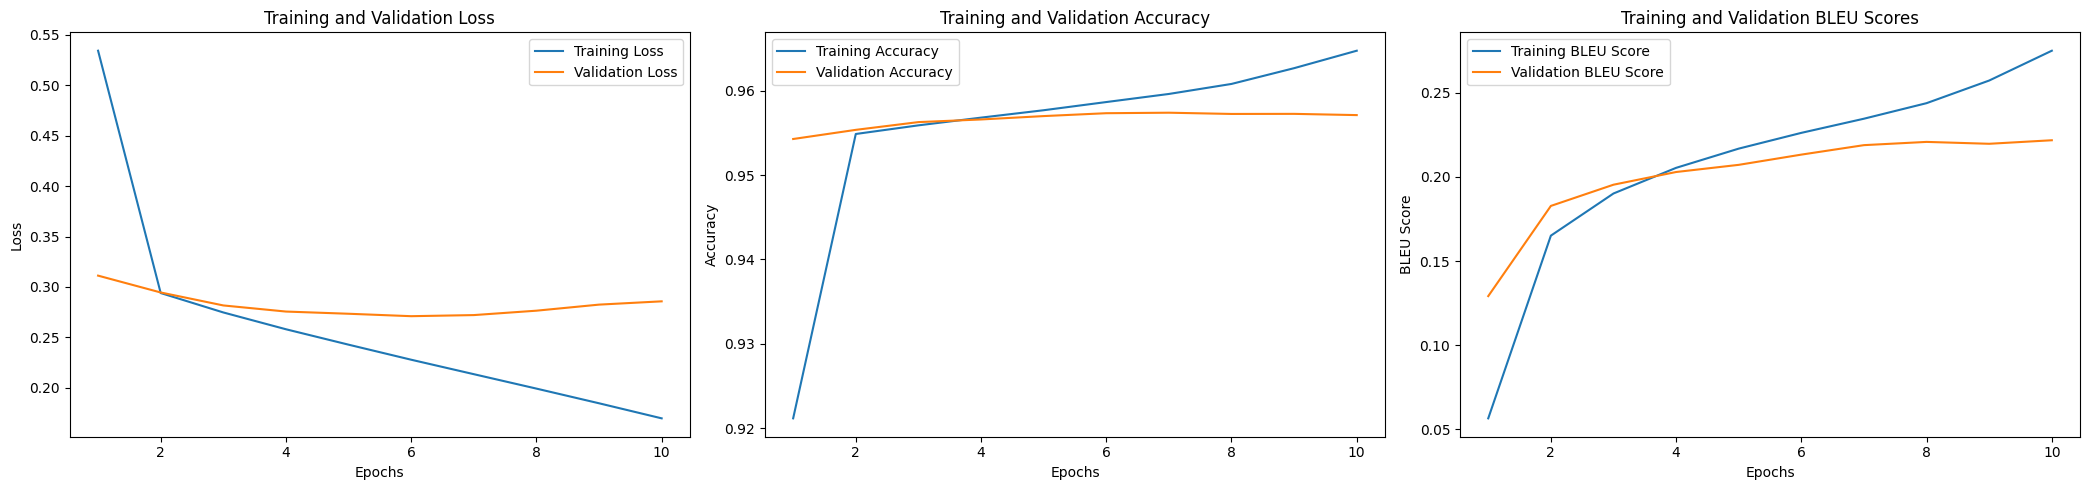

In [13]:
plt.figure(figsize=(21, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 3, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(eplist, bleu_history['train'], label='Training BLEU Score')
plt.plot(eplist, bleu_history['val'], label='Validation BLEU Score')
plt.title('Training and Validation BLEU Scores')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from torch.nn import functional as F
def generate_text_from_image(image_path, model, device, transform, int2word, max_length=256):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    tokens = torch.ones(1, dtype=torch.long).to(device)
    tokens = tokens.unsqueeze(0)
    x = tokens.to(device)
    model.eval()
    while x.size(1) < max_length:
        with torch.no_grad():
            logits = model(image, x)
            logits = logits[:, -1, :]  # Take the logits at the last position
            probs = F.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, 1)
            xcol = torch.gather(topk_indices, -1, ix)
            x = torch.cat((x, xcol), dim=1)
            if xcol.item() == 2:  
                break

    decoded = [int2word[t.item()] for t in x[0]]
    return ' '.join(decoded)

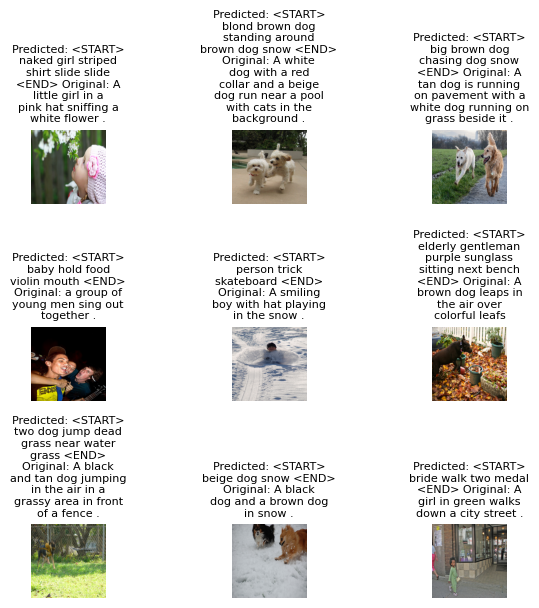

In [15]:
images_folder = '/kaggle/input/flickr8k/Images'
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
num_images = 9
selected_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(3, 3, figsize=(7, 7))  
axs_flat = axs.flatten()

for i, image_file in enumerate(selected_images):
    img = Image.open(os.path.join(images_folder, image_file))
    img_resized = img.resize((256, 256))  
    axs_flat[i].imshow(img_resized)
    axs_flat[i].axis('off')
    predicted_caption = generate_text_from_image(os.path.join(images_folder, image_file), model, device, transform, int2word)
    original_title = captions_by_image[image_file][0]
    full_title = f"Predicted: {predicted_caption}\nOriginal: {original_title}"
    wrapped_title = textwrap.fill(full_title, width=20)
    axs_flat[i].set_title(wrapped_title, fontsize=8) 

plt.tight_layout(pad=4.0, h_pad=1.0, w_pad=1.0)  
plt.show()

### Model's Performance on test dataset

In [16]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 95.7% - Avg loss: 0.277529 - Avg BLEU: 0.227667 

